In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# extraindo o zip
import os
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Datasets/dataset_vc/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/office_not_office')

In [6]:
# definindo os paths no /tmp da virtual machine do Colab
base_dir = '/tmp/office_not_office/dataset'
train_dir = os.path.join(base_dir, 'training_set')
test_dir = os.path.join(base_dir, 'test_set')

In [7]:
# definindo set de treino
training_set = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
seed=101,
image_size=(400, 400),
batch_size=32)

Found 450 files belonging to 2 classes.


In [8]:
# definindo set de teste
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
test_dir,
seed=101,
image_size=(400, 400),
batch_size=32)

Found 170 files belonging to 2 classes.


In [9]:
# testando se o set de treino veio certinho. o output correto deve ser ['office', 'not_office']
class_names = training_set.class_names
class_names

['not_office', 'office']

In [10]:
# obtendo um modelo de aleatorizacao de imagens para evitar overfit
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(400, 400, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [11]:
# CNN com Dropout e BatchNormalization para acelerar o treino

model = Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    tf.keras.layers.BatchNormalization(),  # não tenho certeza se esta linha deveria vir antes ou depois do Dropout
    Dense(1, activation='sigmoid')
])

In [12]:
# Compilando o modelo
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [24]:
# Definindo callbacks para Early Stopping e para Checkpoints que salvam o melhor modelo
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

callbacks = [
             #EarlyStopping(patience=10),
             model_checkpoint_callback,
]

In [29]:
# Treinando o modelo

history = model.fit(training_set,validation_data=validation_set, epochs=40,callbacks=callbacks)

Epoch 1/40
15/15 [==============================] - 104s 7s/step - loss: 0.5160 - binary_accuracy: 0.7267 - val_loss: 0.5736 - val_binary_accuracy: 0.7235
Epoch 2/40
15/15 [==============================] - 104s 7s/step - loss: 0.5266 - binary_accuracy: 0.7244 - val_loss: 0.8328 - val_binary_accuracy: 0.4647
Epoch 3/40
15/15 [==============================] - 104s 7s/step - loss: 0.5073 - binary_accuracy: 0.7489 - val_loss: 0.7142 - val_binary_accuracy: 0.5412
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 4/40
15/15 [==============================] - 104s 7s/step - loss: 0.4876 - binary_accuracy: 0.7578 - val_loss: 0.6450 - val_binary_accuracy: 0.6471
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 5/40
15/15 [==============================] - 104s 7s/step - loss: 0.4869 - binary_accuracy: 0.7511 - val_loss: 0.5699 - val_binary_accuracy: 0.7059
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 6/40
15/15 [==============================] -

In [30]:
# Plotando metricas
metrics_df = pd.DataFrame(history.history)

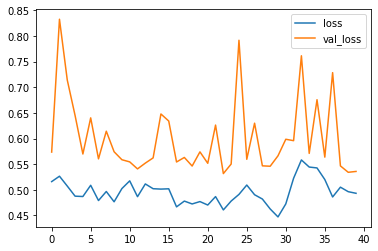

In [31]:
metrics_df[["loss","val_loss"]].plot();

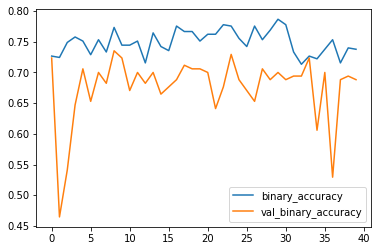

In [32]:
metrics_df[["binary_accuracy","val_binary_accuracy"]].plot();

In [33]:
# Avaliação do modelo
loss, accuracy = model.evaluate(validation_set)
print('Accuracy on test dataset:', accuracy) 

6/6 [==============================] - 9s 1s/step - loss: 0.5359 - binary_accuracy: 0.6882
Accuracy on test dataset: 0.6882352828979492


In [34]:
import numpy as np
# pra pegar X_test  e y_test daqui
print(validation_set)
y_test = np.concatenate([y for x, y in validation_set], axis=0)
X_test = np.concatenate([x for x, y in validation_set], axis=0)
y_test

<BatchDataset shapes: ((None, 400, 400, 3), (None,)), types: (tf.float32, tf.int32)>


array([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1], dtype=int32)

In [35]:
X_test

array([[[[233.25     , 215.875    , 203.375    ],
         [234.625    , 223.5      , 206.375    ],
         [232.75     , 225.375    , 207.       ],
         ...,
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ]],

        [[226.90625  , 217.34766  , 200.88281  ],
         [229.64062  , 222.2539   , 206.14844  ],
         [233.42969  , 226.39453  , 210.17188  ],
         ...,
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ]],

        [[224.03516  , 220.13672  , 201.67969  ],
         [229.125    , 224.55078  , 209.28906  ],
         [232.97266  , 225.76172  , 212.60938  ],
         ...,
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ]],

        ...,

        [[ 90.97266  ,  95.94922  ,  9

In [36]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [37]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

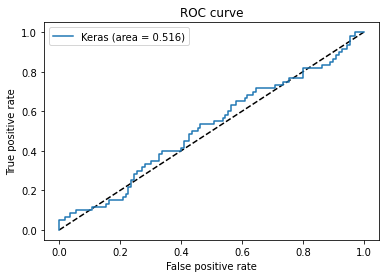

In [38]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()